# Diversification rate analysis

Generate lineages-through-time (LTT) plot, perform gamma test, and fit the tree with the Yule model (pure birth) and the birth-death model, using R packages **ape** and **phytools**.

## R solution

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [13]:
%load_ext rpy2.ipython

In [14]:
%R require(phytools)

array([1], dtype=int32)

In [15]:
%%R
tree <- read.tree("astral.cons.r8s.nwk")
tree


Phylogenetic tree with 10027 tips and 9741 internal nodes.

Tip labels:
	G000830275, G000402355, G000830295, G001871415, G001940645, G001940755, ...
Node labels:
	N1, N2, N4, N8, N9, N5, ...

Rooted; includes branch lengths.


In [16]:
%%R
height <- max(nodeHeights(tree))
height

[1] 4.205978


In [17]:
%%R
size <- length(tree$tip.label)
size

[1] 10027


### LTT plot

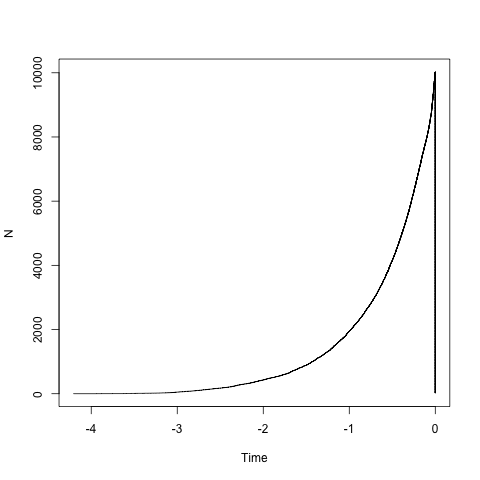

In [18]:
%%R
ltt.plot(tree)

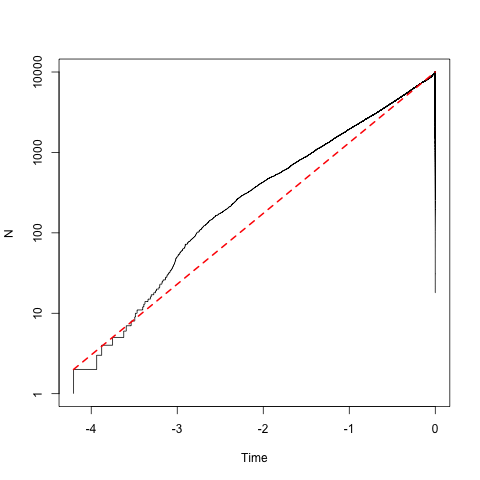

In [19]:
%%R
ltt.plot(tree, log="y")
lines(c(-height, 0), c(2, size), lty="dashed", lwd=2, col="red")

In [20]:
%%R
(log(size) - log(2)) / height

[1] 2.025662


In [21]:
%%R
pdf('ltt.pdf', useDingbats=F)
ltt.plot(tree, log="y", xlab="Time (Ga)", ylab="Lineages")
lines(c(-height, 0), c(2, size), lty="dashed", lwd=2, col="red")
dev.off()

quartz_off_screen 
                2 


Object of class "ltt" containing:

(1) A phylogenetic tree with 10027 tips and 9741 internal nodes.

(2) Vectors containing the number of lineages (ltt) and branching times (times) on the tree.

(3) A value for Pybus & Harvey's "gamma" statistic of 11.1276, p-value = 0.



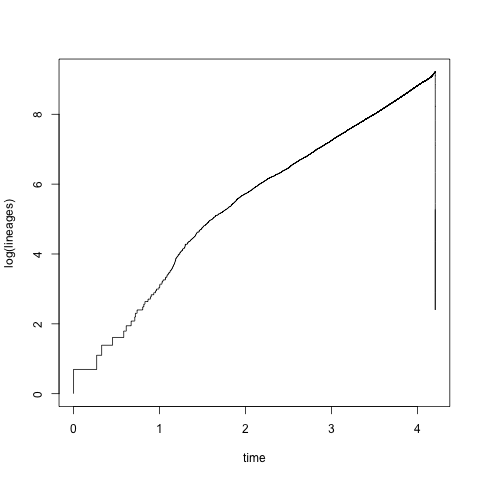

In [22]:
%%R
lttp <- ltt(tree)
lttp

### Model fitting

In [23]:
%%R
tree <- multi2di(tree)

In [24]:
%%R
yule(tree)

$lambda
[1] 1.70456

$se
[1] 0.01702433

$loglik
[1] 77669.83

attr(,"class")
[1] "yule"


In [25]:
%%R
birthdeath(tree)


Estimation of Speciation and Extinction Rates
            with Birth-Death Models

     Phylogenetic tree: tree 
        Number of tips: 10027 
              Deviance: -155449.1 
        Log-likelihood: 77724.56 
   Parameter estimates:
      d / b = 0.3059216   StdErr = 0.01773354 
      b - d = 1.417726   StdErr = 0.02248681 
   (b: speciation rate, d: extinction rate)
   Profile likelihood 95% confidence intervals:
      d / b: [0.2815394, 0.3294772]
      b - d: [1.387572, 1.448327]



## (Obsolete) homebrew solution

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from skbio import TreeNode

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
tree = TreeNode.read('astral.cons.r8s.nwk')
tree.count(tips=True)

10027

In [4]:
for node in tree.postorder(include_self=True):
    node.n = 1 if node.is_tip() else len(node.children)

In [5]:
heights = {'N1': 0.0}
for node in tree.preorder(include_self=False):
    heights[node.name] = heights[node.parent.name] + node.length

In [6]:
present = max(heights.values())
'%.3f' % present

'4.206'

In [7]:
bins = int(present * 10) + 1
bins

43

In [8]:
heights = sorted(heights.items(), key=lambda x: x[1], reverse=True)

In [9]:
lineages = [(0, tree.count(tips=True))]
i = 0
n = len(heights)
for b in range(bins):
    x = []
    date = - (b + 1) / 10
    bound = present + date
    if bound < 0:
        lineages.append((date, 1))
    else:
        to_del = []
        while True:
            try:
                id_, height = heights[i]
            except IndexError:
                break
            if height > bound:
                to_del.append(id_)
                i += 1
            else:
                break
        if to_del:
            to_del = set(to_del)
            tree.remove_deleted(lambda x: x.name in to_del)
            lineages.append((date, sum(
                x.n for x in tree.tips(include_self=True))))
        else:
            lineages.append((date, lineages[-1][1]))
lineages = lineages[::-1]

In [10]:
df = pd.DataFrame(lineages, columns=['time', 'lineages'])
df.head()

,time,lineages
0,-4.3,1
1,-4.2,2
2,-4.1,2
3,-4.0,2
4,-3.9,2


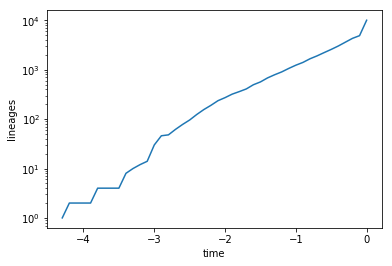

In [11]:
ax = sns.lineplot(x='time', y='lineages', data=df);
ax.set_yscale('log')

In [12]:
fig = ax.get_figure()
fig.tight_layout()
fig.savefig('ltt_homebrew.pdf', bbox_to_inches='tight')